# Testing for FCC Cats and Dogs Project

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

In [2]:
def view_random_image(target_dir, target_class):
    # Setup the target directory
    target_folder = target_dir + '/' + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + '/'  + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    # Show the shape of the image
    print(f'Image shape: {img.shape}')
    
    return img

['dog.976.jpg']
Image shape: (431, 500, 3)


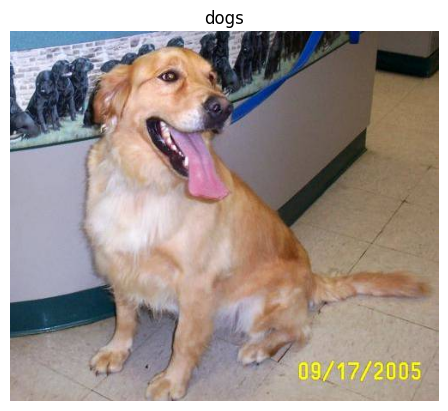

In [3]:
# View a random image from the training data set
img = view_random_image('cats_and_dogs/train', 'dogs')

In [4]:
# Create train and test data generators to rescale the data

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

train_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

2023-01-05 15:33:52.982363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 15:33:53.199580: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-05 15:33:53.249351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-05 15:33:53.249364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
# Set global seed for reproducability
#tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [8]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')
# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [9]:
# Load in our image data and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=32)

                                    
val_data = val_datagen.flow_from_directory(directory=val_dir, 
                                               target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=32)

test_data = test_datagen.flow_from_directory(directory='cats_and_dogs',
                                                    target_size=(150,150),
                                                    batch_size=50,
                                                    classes=['test'],                                             
                                                    class_mode=None,
                                                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [10]:
# Check classes found
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
{'test': 0}


## Evaluation Functions

In [11]:
# plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs we ran for
    
    # plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    # plot accuracy
    plt.figure() # create a 2nd figure
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

In [12]:
def test_score(model, test_data):
    probabilities = np.ndarray.flatten(model.predict(test_data))
        
    answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
                1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
                1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
                1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
                0, 0, 0, 0, 0, 0]

    correct = 0

    for probability, answer in zip(probabilities, answers):
      if round(probability) == answer:
        correct +=1

    percentage_identified = (correct / len(answers)) * 100

    passed_challenge = percentage_identified >= 63

    print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

    if passed_challenge:
      print("You passed the challenge!")
    else:
      print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

## Model 1 - Baseline

In [17]:
# Create the baseline model
model_1 = Sequential([
    Conv2D(10, kernel_size=3, activation='relu', input_shape=(150,150,3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [18]:
model_1.compile(loss='binary_crossentropy', 
                optimizer=Adam(), 
                metrics=['accuracy'])

In [19]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 conv2d_4 (Conv2D)           (None, 146, 146, 10)      910       
                                                                 
 conv2d_5 (Conv2D)           (None, 144, 144, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 207360)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 207361    
                                                                 
Total params: 209,461
Trainable params: 209,461
Non-trainable params: 0
_________________________________________________________________


In [20]:
len(train_data), train_data.n / 32

(63, 62.5)

In [127]:
history_1 = model_1.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 5s 76ms/step - loss: 0.6910 - accuracy: 0.5540 - val_loss: 0.6631 - val_accuracy: 0.5990
Epoch 2/5
63/63 [==============================] - 5s 75ms/step - loss: 0.6425 - accuracy: 0.6510 - val_loss: 0.6649 - val_accuracy: 0.5890
Epoch 3/5
63/63 [==============================] - 6s 102ms/step - loss: 0.5156 - accuracy: 0.7485 - val_loss: 0.6637 - val_accuracy: 0.6350
Epoch 4/5
63/63 [==============================] - 7s 114ms/step - loss: 0.3451 - accuracy: 0.8525 - val_loss: 0.7221 - val_accuracy: 0.6220
Epoch 5/5
63/63 [==============================] - 8s 121ms/step - loss: 0.2064 - accuracy: 0.9265 - val_loss: 1.0856 - val_accuracy: 0.6130


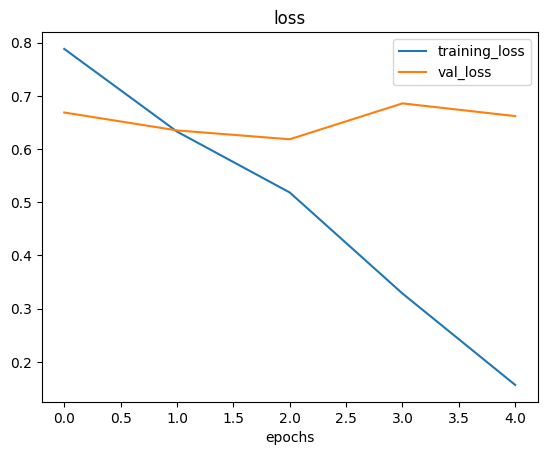

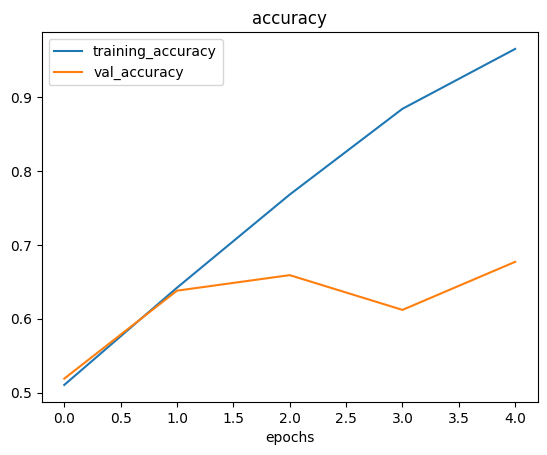

In [107]:
# Check out the loss and accuracy of model_1
plot_loss_curves(history_1)

In [108]:
model_1.evaluate(val_data)

32/32 [==============================] - 1s 30ms/step - loss: 0.6619 - accuracy: 0.6770


[0.6619464755058289, 0.6769999861717224]

In [109]:
test_score(model_1, test_data)

1/1 [==============================] - 0s 114ms/step
Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


## Model 2 - Add Max Pooling

In [29]:
model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [30]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 10)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 10)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 10)        910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 10)      

In [31]:
model_2.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

In [32]:
history_2 = model_2.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 3s 47ms/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6882 - val_accuracy: 0.5050
Epoch 2/5
63/63 [==============================] - 3s 44ms/step - loss: 0.6836 - accuracy: 0.5390 - val_loss: 0.6744 - val_accuracy: 0.5130
Epoch 3/5
63/63 [==============================] - 3s 44ms/step - loss: 0.6721 - accuracy: 0.5830 - val_loss: 0.6636 - val_accuracy: 0.6170
Epoch 4/5
63/63 [==============================] - 3s 45ms/step - loss: 0.6298 - accuracy: 0.6405 - val_loss: 0.6174 - val_accuracy: 0.6530
Epoch 5/5
63/63 [==============================] - 3s 47ms/step - loss: 0.5830 - accuracy: 0.6935 - val_loss: 0.6043 - val_accuracy: 0.6510


In [33]:
model_2.evaluate(val_data)

32/32 [==============================] - 1s 26ms/step - loss: 0.6043 - accuracy: 0.6510


[0.6043184995651245, 0.6510000228881836]

In [34]:
test_score(model_2, test_data)

1/1 [==============================] - 0s 103ms/step
Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


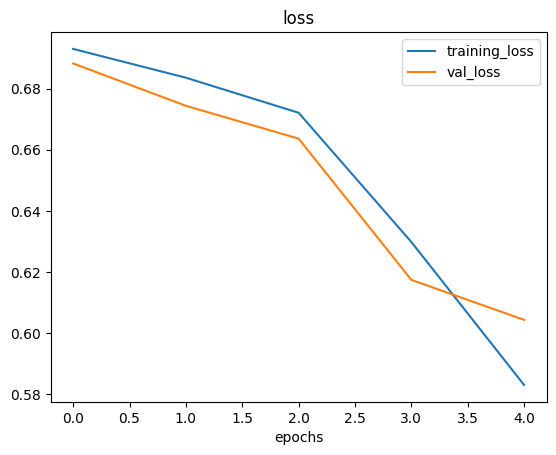

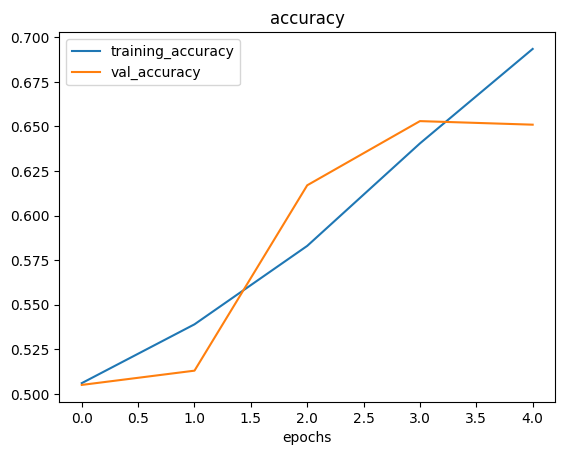

In [35]:
plot_loss_curves(history_2)

## Model 3 - Add More Filters

In [53]:
model_3 = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [54]:
model_3.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics='accuracy')

In [55]:
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 32)      

In [56]:
history_3 = model_3.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 6s 97ms/step - loss: 0.6909 - accuracy: 0.5320 - val_loss: 0.6631 - val_accuracy: 0.6150
Epoch 2/5
63/63 [==============================] - 6s 95ms/step - loss: 0.6481 - accuracy: 0.6250 - val_loss: 0.6456 - val_accuracy: 0.6030
Epoch 3/5
63/63 [==============================] - 8s 125ms/step - loss: 0.5982 - accuracy: 0.6595 - val_loss: 0.6200 - val_accuracy: 0.6640
Epoch 4/5
63/63 [==============================] - 8s 130ms/step - loss: 0.5447 - accuracy: 0.7200 - val_loss: 0.5694 - val_accuracy: 0.7070
Epoch 5/5
63/63 [==============================] - 8s 129ms/step - loss: 0.5090 - accuracy: 0.7525 - val_loss: 0.5663 - val_accuracy: 0.7110


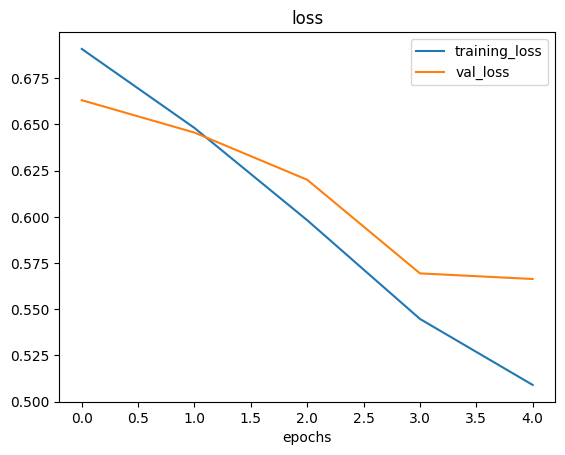

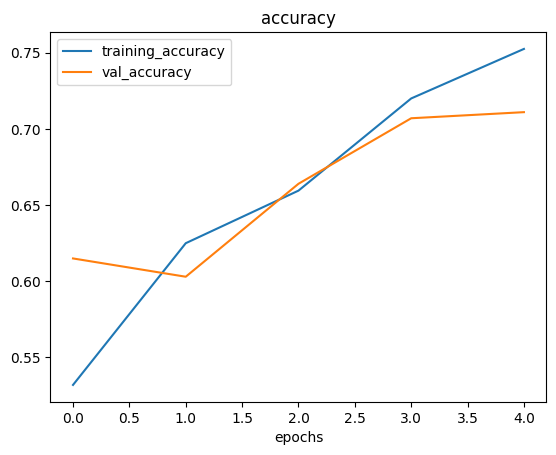

In [57]:
plot_loss_curves(history_3)

In [58]:
model_3.evaluate(val_data)

32/32 [==============================] - 1s 31ms/step - loss: 0.5663 - accuracy: 0.7110


[0.5663402676582336, 0.7110000252723694]

In [59]:
test_score(model_3, test_data)

1/1 [==============================] - 0s 138ms/step
Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
